[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を参考に、エージェントを作成する。FXの自動取引を行い、利益を出すのが目標。

In [ ]:
import numpy as np
import pandas as pd
from logging import getLogger, StreamHandler, DEBUG, INFO

from hist_data import HistData
from fx_trade import FXTrade
from deep_fx import DeepFX

Using TensorFlow backend.


In [ ]:
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(INFO)
logger.setLevel(INFO)
logger.addHandler(handler)

In [ ]:
h = HistData('2010/9')

In [ ]:
env = FXTrade(1000000, 0.08, h, logger=logger)
#env = FXTrade(1000000, 0.08, h, logger=logger)
prepared_model_filename = None #'Keras-RL_DQN_FX_model_meanq1.440944e+06_episode00003.h5'
dfx = DeepFX(env, 'test', prepared_model_filename=prepared_model_filename)

In [ ]:
is_to_train = True
if is_to_train:
    dfx.train(is_for_time_measurement=True)
else:
    dfx.test(1, [EpisodeLogger()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None
17/10/29 20:05:34
Training for 14390 steps ...
Training for 14390 steps ...
_reset START
self._seed: 100000
Start datetime: 2010-09-01T00:00:00.000000000
_reset END


2010-09-02 00:00:00 84.420000
2010-09-03 00:00:00 84.270000
2010-09-06 00:00:00 84.130000
2010-09-07 00:00:00 84.210000
2010-09-08 00:00:00 83.810000
2010-09-09 00:00:00 83.860000
2010-09-10 00:00:00 83.800000
2010-09-13 00:00:00 84.220000
2010-09-14 00:00:00 83.690000
2010-09-15 00:00:00 83.030000


done, took 131.176 seconds
done, took 131.175 seconds
elapsed_time:131.21253442764282[sec]
17/10/29 20:07:45


<IPython.core.display.Javascript object>


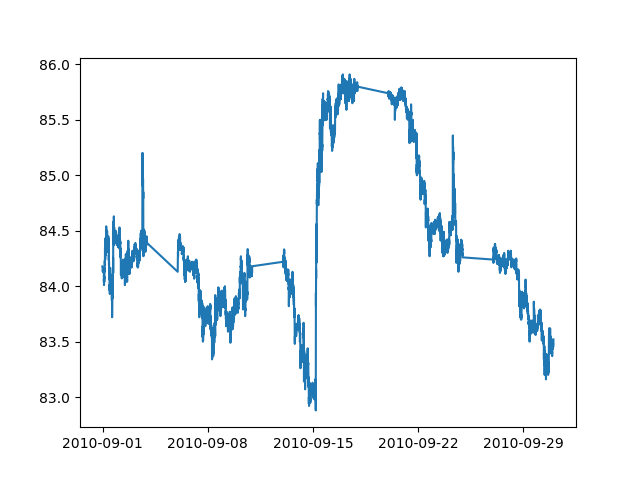

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
data = h.data()['2010-09']['Close']
x = data.index
y  = data.values
plt.plot(x, y)

In [ ]:
data.values